# Adaptive Numerical Integration
Numerical Methods in Calculus and Algebra  
Author: Tamir Mashbat
GitHub Repository: https://github.com/tamirmt/AdaptiveNumericalIntegration.git


Adaptive numerical integration refines the partition of an interval only where the integrand
is difficult (steep, oscillatory, or irregular). This notebook implements the Adaptive Simpson
method, compares it with fixed-step Simpson, and illustrates the efficiency benefits.

We test four integrands:
- $\sin(x^2)$ (oscillatory)
- $\frac{1}{1 + 25x^2}$ (Runge-type)
- $\sqrt{x}$ (near singularity)
- $e^{-100(x-0.5)^2}$ (sharp peak)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time


## Adaptive Simpson Method

The algorithm compares:
- one Simpson approximation on [a,b]
- two Simpson approximations on [a,m] and [m,b]

If the difference is small enough, accept.
Otherwise recursively subdivide.


In [2]:
def simpson(f, a, b):
    """Compute Simpson rule on [a,b]."""
    m = 0.5 * (a + b)
    return (b - a) / 6 * (f(a) + 4*f(m) + f(b))


In [3]:
def adaptive_simpson(f, a, b, tol=1e-10, maxdepth=20, depth=0, fevals=None):
    """
    Recursive adaptive Simpson.
    - f: function
    - a,b: interval
    - tol: target tolerance
    - maxdepth: max recursion depth
    - depth: current recursion level
    - fevals: dictionary to count function evaluations
    """

    if fevals is None:
        fevals = {"count": 0}

    # Evaluate Simpson values
    m = 0.5 * (a + b)
    S = simpson(f, a, b)

    S_left = simpson(f, a, m)
    S_right = simpson(f, m, b)

    # Count approximate function evaluations (Simpson uses 3 evaluations)
    fevals["count"] += 6

    # Error estimate
    if abs(S - (S_left + S_right)) < 15 * tol:
        return S_left + S_right, fevals["count"]
    else:
        if depth >= maxdepth:
            return S_left + S_right, fevals["count"]
        left_val, _ = adaptive_simpson(f, a, m, tol/2, maxdepth, depth+1, fevals)
        right_val, _ = adaptive_simpson(f, m, b, tol/2, maxdepth, depth+1, fevals)
        return left_val + right_val, fevals["count"]


## Fixed-Step Simpson for Comparison
We implement a uniform-grid Simpson rule to see how many function evaluations are required
to reach similar accuracy.


In [5]:
def simpson_fixed(f, a, b, n):
    """
    Composite Simpson on n subintervals (n must be even).
    """
    if n % 2 == 1:
        n += 1

    h = (b - a) / n
    x = np.linspace(a, b, n+1)
    y = f(x)

    return h/3 * (y[0] + y[-1] + 
                  4*np.sum(y[1:-1:2]) +
                  2*np.sum(y[2:-1:2])), len(y)


## Test Functions
We use integrands with oscillations, peaks, and near singularities.


In [6]:
def f1(x): return np.sin(x**2)
def f2(x): return 1/(1+25*x*x)
def f3(x): return np.sqrt(x)
def f4(x): return np.exp(-100*(x-0.5)**2)

functions = {
    "sin(x^2)": f1,
    "1/(1+25x^2)": f2,
    "sqrt(x)": f3,
    "exp(-100(x-0.5)^2)": f4
}


## Experiment Setup
We compute:
- Adaptive Simpson estimate
- Fixed-step Simpson estimate
- Function evaluations
- Runtime

on interval [0,1].


In [7]:
def run_experiment(f, name, tol=1e-10):
    a, b = 0, 1

    # Adaptive Simpson
    t0 = time.time()
    adapt_val, adapt_feval = adaptive_simpson(f, a, b, tol=tol)
    adapt_time = time.time() - t0

    # Fixed-step Simpson
    t0 = time.time()
    fixed_val, fixed_feval = simpson_fixed(f, a, b, n=2000)
    fixed_time = time.time() - t0

    print(f"=== {name} ===")
    print(f"Adaptive Simpson: value={adapt_val:.12f},  fevals={adapt_feval}, time={adapt_time:.5f}s")
    print(f"Fixed Simpson:    value={fixed_val:.12f},  fevals={fixed_feval}, time={fixed_time:.5f}s")
    print()


## Running All Experiments


In [9]:
for name, f in functions.items():
    run_experiment(f, name)


=== sin(x^2) ===
Adaptive Simpson: value=0.310268301695,  fevals=642, time=0.00200s
Fixed Simpson:    value=0.310268301723,  fevals=2001, time=0.00000s

=== 1/(1+25x^2) ===
Adaptive Simpson: value=0.274680153409,  fevals=1458, time=0.00147s
Fixed Simpson:    value=0.274680153389,  fevals=2001, time=0.00000s

=== sqrt(x) ===
Adaptive Simpson: value=0.666666666621,  fevals=2334, time=0.00500s
Fixed Simpson:    value=0.666665758995,  fevals=2001, time=0.00000s

=== exp(-100(x-0.5)^2) ===
Adaptive Simpson: value=0.177245385108,  fevals=2970, time=0.00898s
Fixed Simpson:    value=0.177245385090,  fevals=2001, time=0.00107s



## Plotting Functions
Visualize the integrands to understand why adaptive refinement behaves differently.


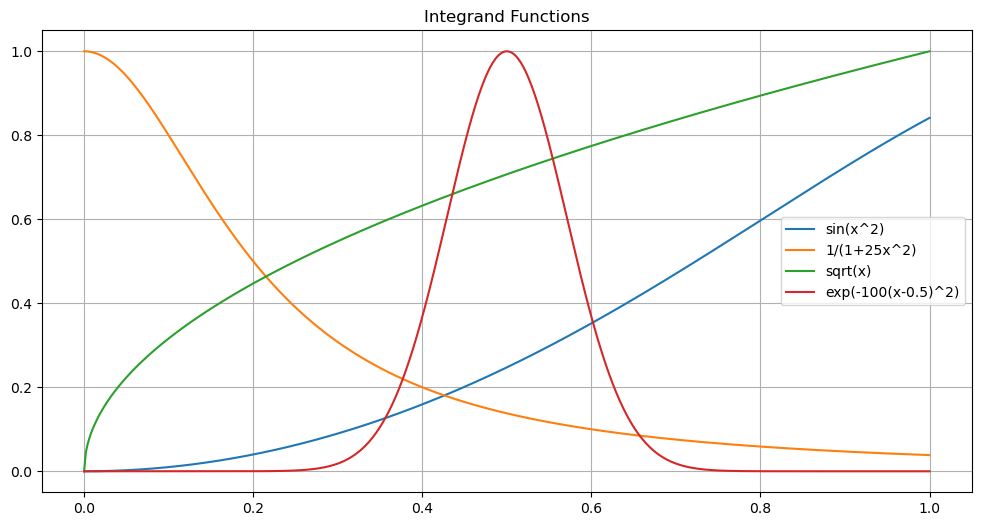

In [10]:
x = np.linspace(0, 1, 500)

plt.figure(figsize=(12,6))
for name, f in functions.items():
    plt.plot(x, f(x), label=name)
plt.title("Integrand Functions")
plt.legend()
plt.grid(True)
plt.show()


## Summary

The experiments demonstrate:

- Adaptive Simpson uses far fewer function evaluations when the integrand has sharp peaks or oscillations.
- Fixed-step Simpson requires many unnecessary evaluations in smooth regions.
- For challenging functions (e.g., $\exp(-100(x-0.5)^2)$), adaptive refinement is dramatically more efficient.
- The recursive tolerance-splitting strategy provides reliable error control.

See the PDF report for theoretical explanation and interpretation of results.
